In [1]:
# =====================================================
# Imports
# =====================================================
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from collections import defaultdict

# Custom modules
from env import PortfolioEnv
from data_utils import (
    get_ohlcv_data, 
    get_indicators, 
    get_sentiment_data_from_csv, 
    train_test_split_data, 
    benchmark
)
from plot_utils import (
    plot_close_price, 
    plot_indicators, 
    plot_sentiments, 
    plot_training_results, 
    plot_portfolio_evaluation, 
    compare_performance
)
from agent.a2c import A2CAgent
from agent.ddpg import DDPGAgent
from agent.td3 import TD3Agent
from agent.ppo import PPOAgent


In [2]:
# Plotting style
sns.set_theme(style="whitegrid")

In [3]:
# Global random seed
SEED = 42

In [4]:
# =====================================================
# Utility Functions
# =====================================================
def set_global_seed(seed=42):
    """
    Ensure reproducibility by setting random seeds for Python, NumPy, and PyTorch.
    """
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Ensures deterministic behavior for CuDNN operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def load_or_train(agent, checkpoint_path, train=True):
    """
    Load a trained agent from checkpoint if available,
    otherwise train a new agent and save it.
    """
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path} ...")
        agent.load_checkpoint(checkpoint_path)
        rewards_history = getattr(agent, "training_rewards", [])
    elif train:
        print(f"Training agent and saving checkpoint to {checkpoint_path} ...")
        rewards_history = agent.train()
        agent.save_checkpoint(checkpoint_path)
    else:
        rewards_history = []
    return rewards_history


In [5]:
# =====================================================
# Data Loading & Preprocessing
# =====================================================
set_global_seed(SEED)

# Load financial OHLCV data
ohlcv_data = get_ohlcv_data()

# Compute technical indicators
indicators = get_indicators(ohlcv_data)

# Load sentiment data aligned with OHLCV data
sentiments = get_sentiment_data_from_csv(ohlcv_data)

[*********************100%***********************]  11 of 11 completed


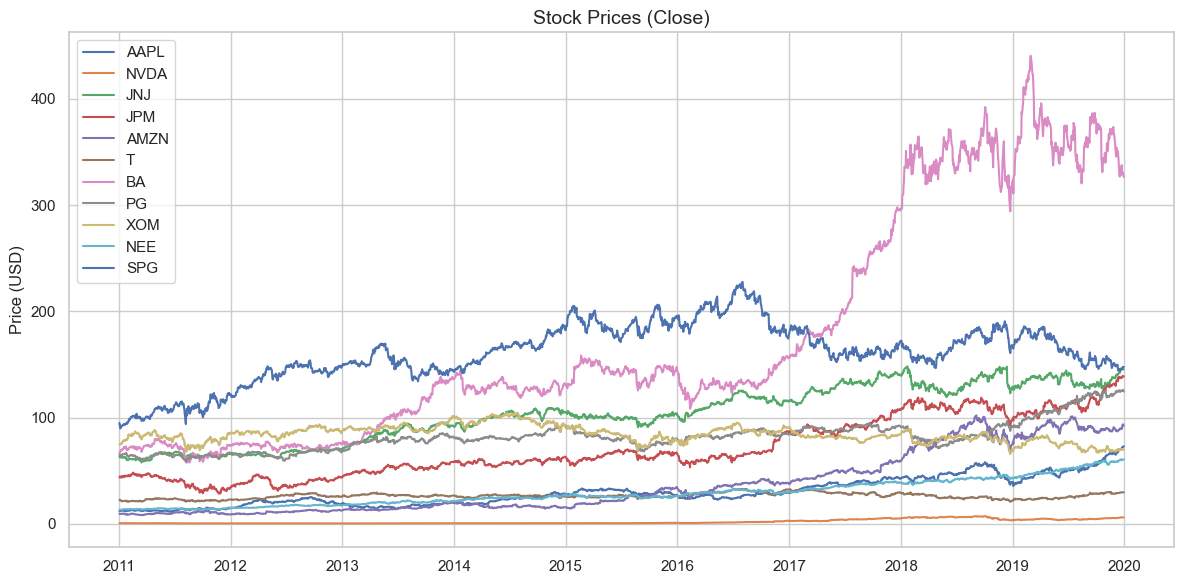

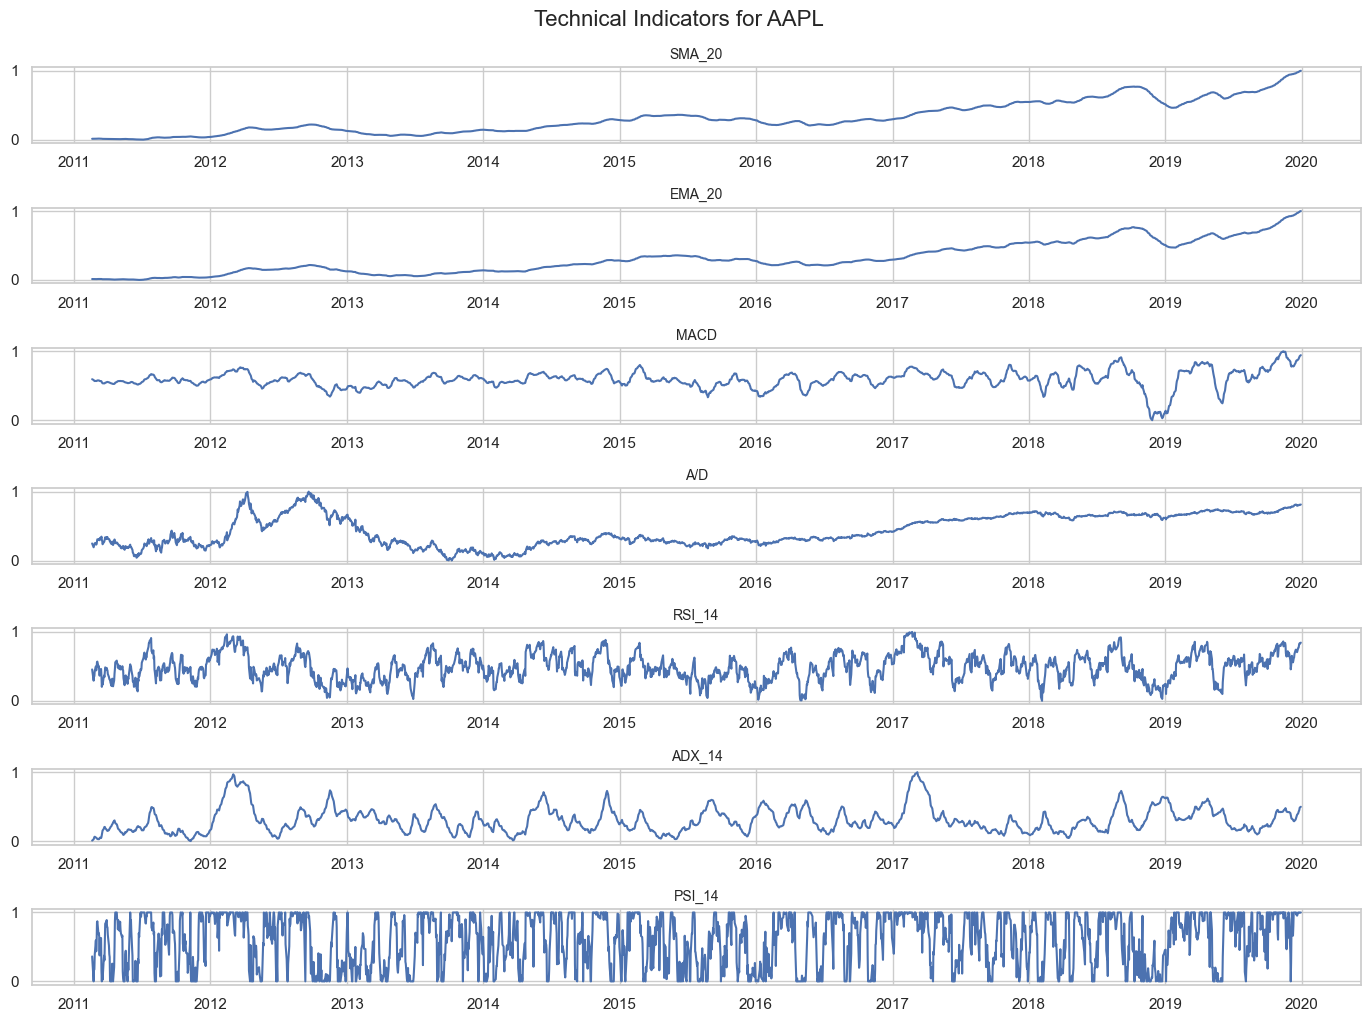

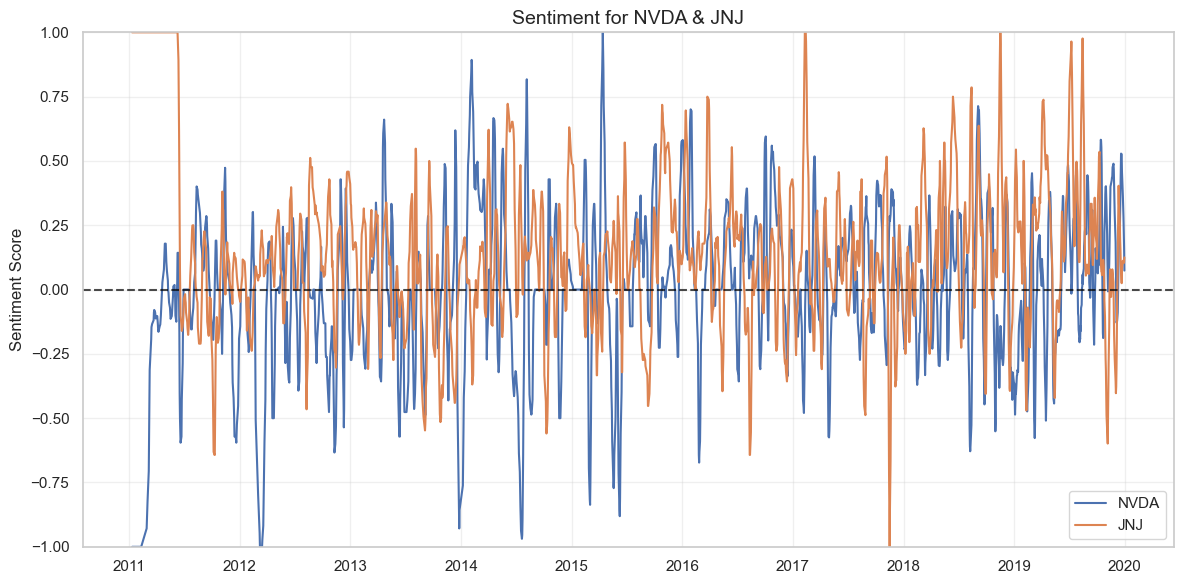

In [6]:
# =====================================================
# Exploratory Plots
# =====================================================
plot_close_price(ohlcv_data)
plot_indicators(indicators, 'AAPL', ['SMA_20', 'EMA_20', 'MACD', 'A/D', 'RSI_14', 'ADX_14', 'PSI_14'])
plot_sentiments(sentiments, tickers=["NVDA", "JNJ"], title="Sentiment for NVDA & JNJ")


In [7]:
# =====================================================
# Train/Test Split (Experiment Setup)
# =====================================================
# Example: Price + indicators + sentiments
price_train, price_test, indicator_train, indicator_test, sentiment_train, sentiment_test = train_test_split_data(
    ohlcv_data['Close'], indicators, sentiments, train_ratio=0.8
)

# Training environment
train_env = PortfolioEnv(price_train, indicator_train, sentiment_train, initial_balance=10000)
train_env.reset(seed=SEED)

# Separate test environments for each agent
a2c_test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)
ddpg_test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)
td3_test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)
ppo_test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)

In [8]:
# =====================================================
# Training Parameters
# =====================================================
episodes = 750
max_steps = train_env.max_steps
CHECKPOINT_DIR = "./checkpoints/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Paths for saving/loading checkpoints
A2C_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "a2c_checkpoint.pth")
DDPG_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "ddpg_checkpoint.pth")
TD3_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "td3_checkpoint.pth")
PPO_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "ppo_checkpoint.pth")

Loading checkpoint from ./checkpoints/a2c_checkpoint.pth ...
[A2C] Checkpoint loaded ← ./checkpoints/a2c_checkpoint.pth (episodes=750, rewards=750)
A2C Test Reward: 0.21
A2C Cumulative Return: 0.2282
A2C Annualized Return: 0.1456
A2C Annualized Volatility: 0.1437
A2C Sharpe Ratio: 1.0183
A2C Max Drawdown: 0.1917

Final Allocation Percentages:
  AAPL: 10.32%
  NVDA: 10.21%
  JNJ: 8.12%
  JPM: 7.50%
  AMZN: 8.80%
  T: 10.91%
  BA: 6.94%
  PG: 9.20%
  XOM: 8.81%
  NEE: 9.07%
  SPG: 10.12%


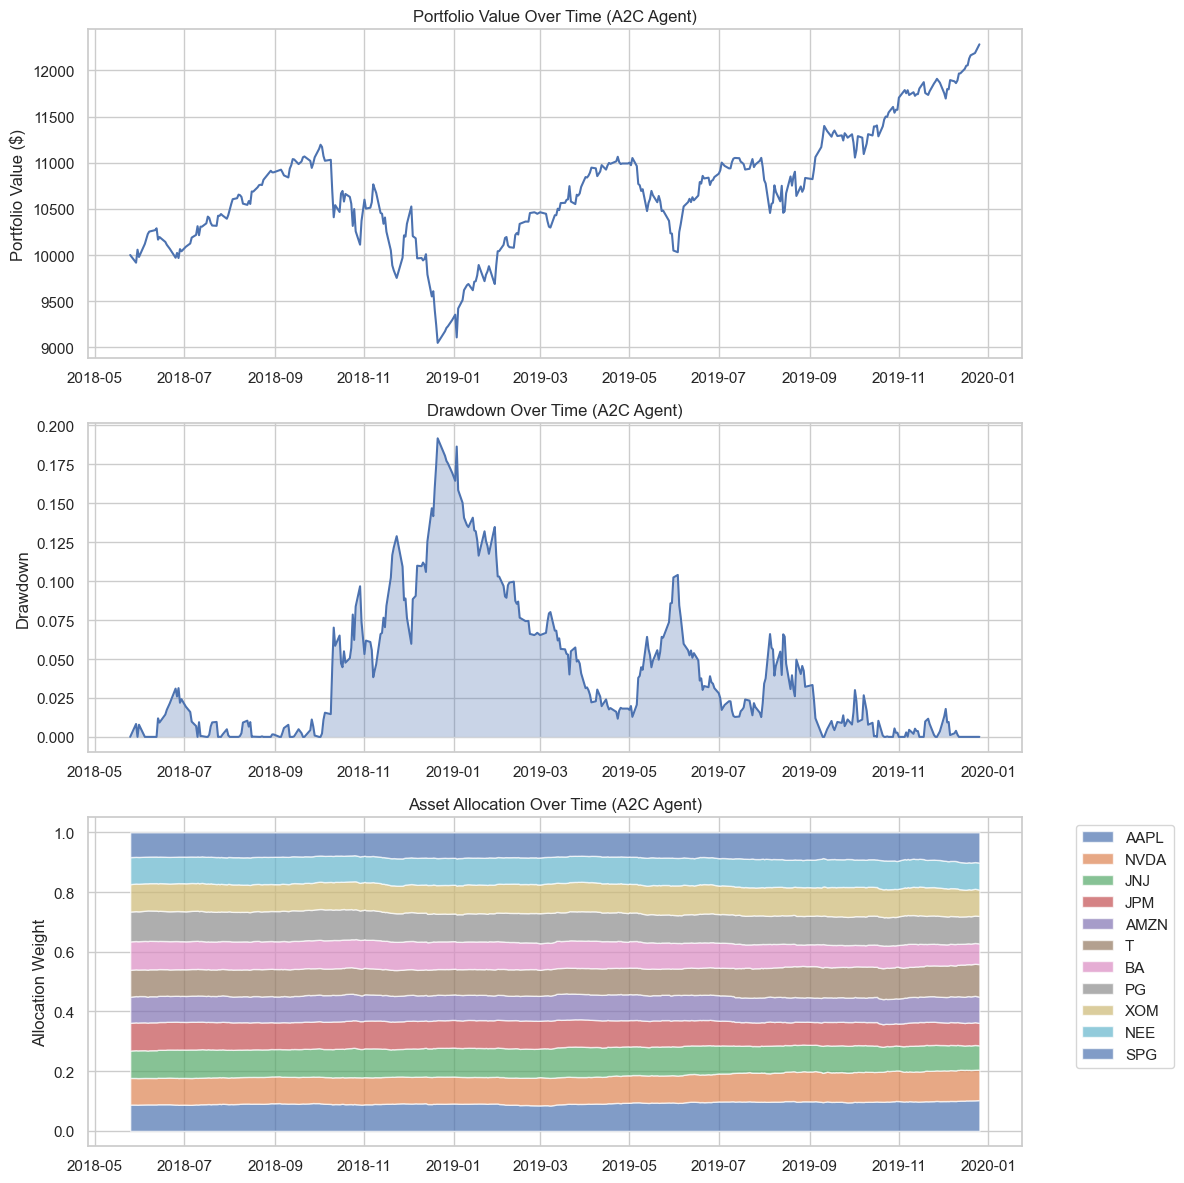

In [9]:
# =====================================================
# Train & Evaluate Agents
# =====================================================

# -----------------------
# A2C Agent
# -----------------------
a2c_agent = A2CAgent(
    train_env,
    max_steps=max_steps,
    episodes=episodes,
    learning_rate=0.001,
    seed=SEED
)
a2c_rewards_history = load_or_train(a2c_agent, A2C_CHECKPOINT_PATH)

# Test A2C
a2c_test_reward, a2c_values, a2c_allocations = a2c_agent.test(a2c_test_env)
print(f"A2C Test Reward: {a2c_test_reward:.2f}")
a2c_metrics = a2c_test_env.evaluate_performance()
for metric, value in a2c_metrics.items():
    print(f"A2C {metric}: {value:.4f}")

plot_portfolio_evaluation(a2c_test_env, title_suffix="(A2C Agent)")


Loading checkpoint from ./checkpoints/ddpg_checkpoint.pth ...
DDPG loaded <- ./checkpoints/ddpg_checkpoint.pth
DDPG Cumulative Return: 0.1808
DDPG Annualized Return: 0.1162
DDPG Annualized Volatility: 0.1589
DDPG Sharpe Ratio: 0.7718
DDPG Max Drawdown: 0.2190


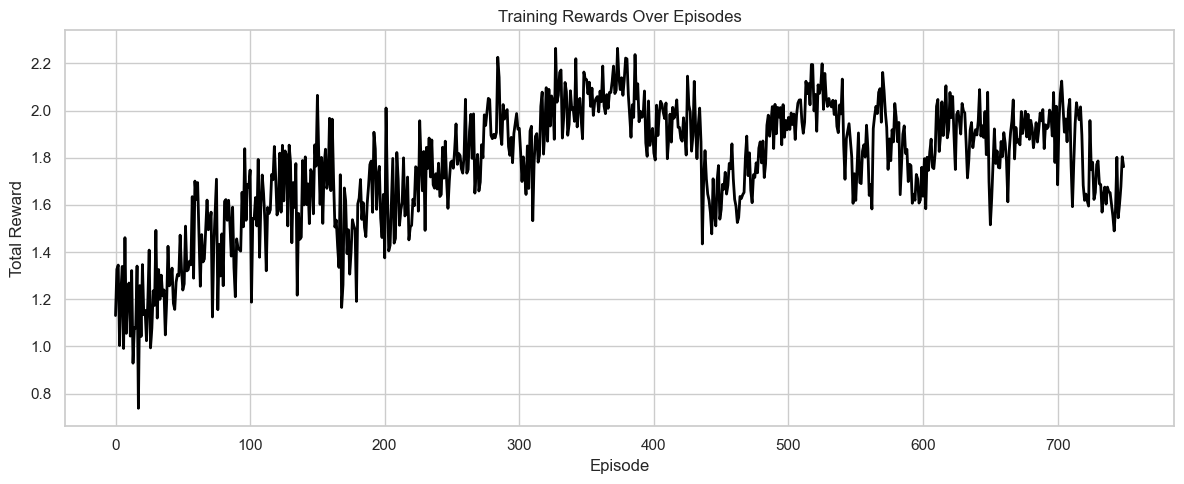


Final Allocation Percentages:
  AAPL: 9.64%
  NVDA: 3.47%
  JNJ: 8.20%
  JPM: 11.83%
  AMZN: 9.90%
  T: 8.25%
  BA: 12.23%
  PG: 7.68%
  XOM: 9.28%
  NEE: 10.31%
  SPG: 9.21%


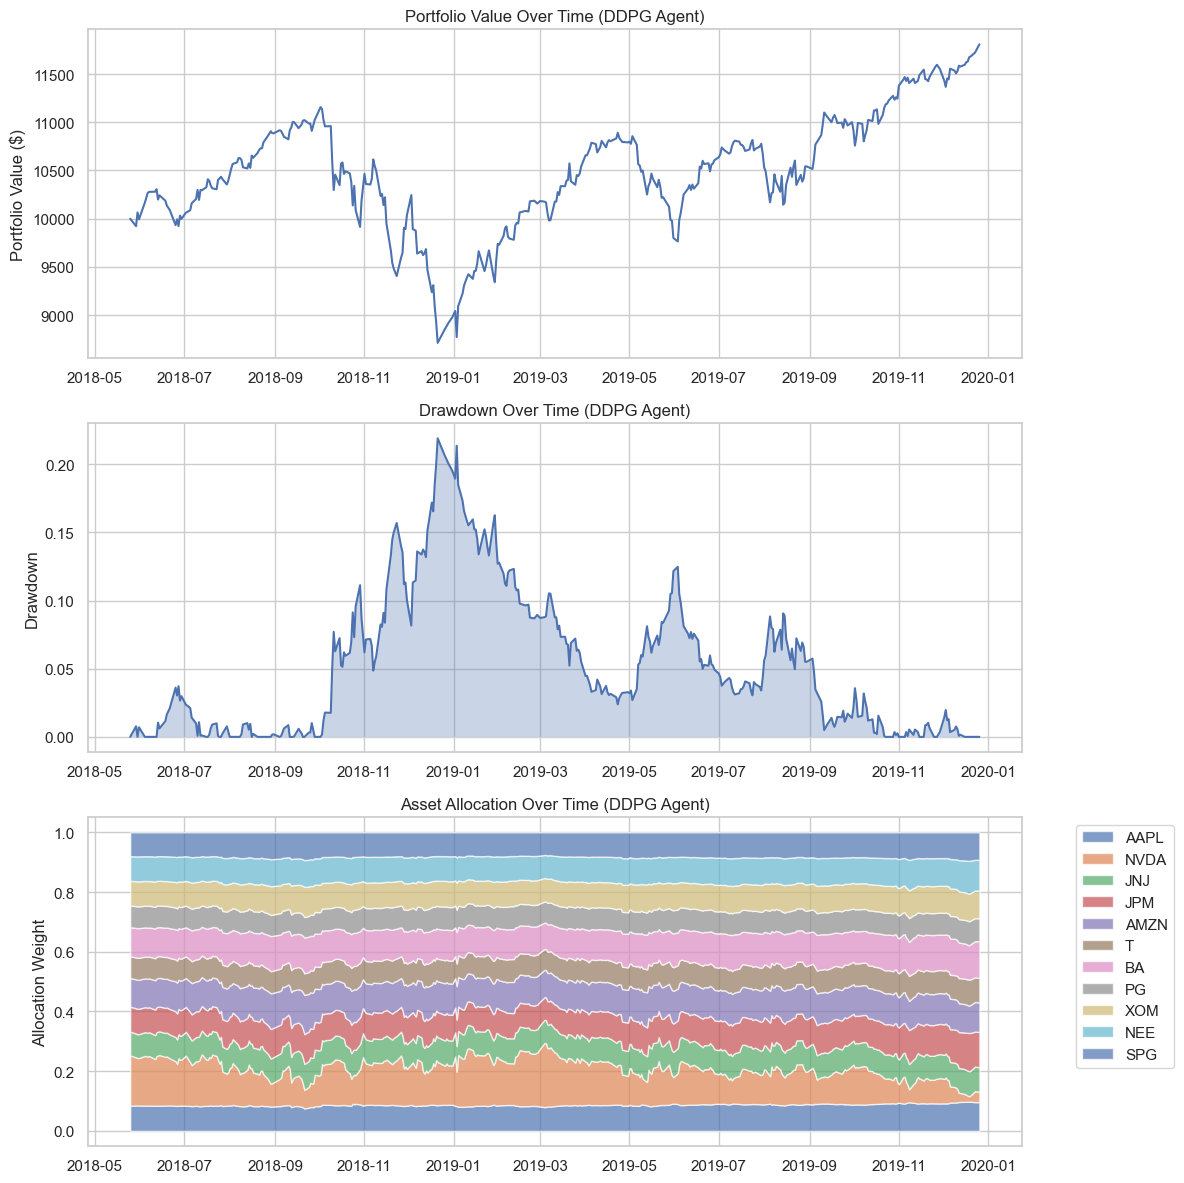

In [10]:
# -----------------------
# DDPG Agent
# -----------------------
ddpg_agent = DDPGAgent(
    env=train_env,
    episodes=episodes,
    actor_lr=1e-4,
    critic_lr=1e-3,
    buffer_size=int(2e5),
    batch_size=256,
    warmup_steps=1000,
    noise_start=0.2,
    noise_end=0.05,
    noise_decay_episodes=episodes // 2,
    seed=SEED
)
ddpg_rewards = load_or_train(ddpg_agent, DDPG_CHECKPOINT_PATH)

ddpg_test_reward, ddpg_values, ddpg_allocations = ddpg_agent.test(ddpg_test_env)
ddpg_metrics = ddpg_test_env.evaluate_performance()
for metric, value in ddpg_metrics.items():
    print(f"DDPG {metric}: {value:.4f}")

plot_training_results([ddpg_rewards])
plot_portfolio_evaluation(ddpg_test_env, title_suffix="(DDPG Agent)")

Loading checkpoint from ./checkpoints/td3_checkpoint.pth ...
TD3 checkpoint loaded from ./checkpoints/td3_checkpoint.pth
TD3 Cumulative Return: 0.2026
TD3 Annualized Return: 0.1298
TD3 Annualized Volatility: 0.1569
TD3 Sharpe Ratio: 0.8568
TD3 Max Drawdown: 0.2150


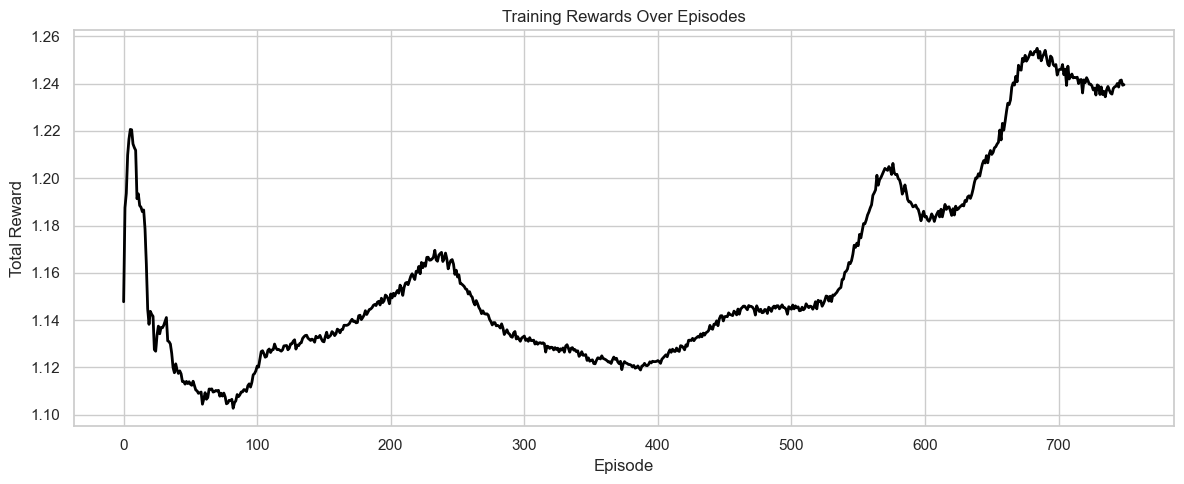


Final Allocation Percentages:
  AAPL: 9.96%
  NVDA: 13.46%
  JNJ: 7.06%
  JPM: 8.15%
  AMZN: 7.95%
  T: 4.50%
  BA: 11.34%
  PG: 7.56%
  XOM: 12.81%
  NEE: 10.43%
  SPG: 6.79%


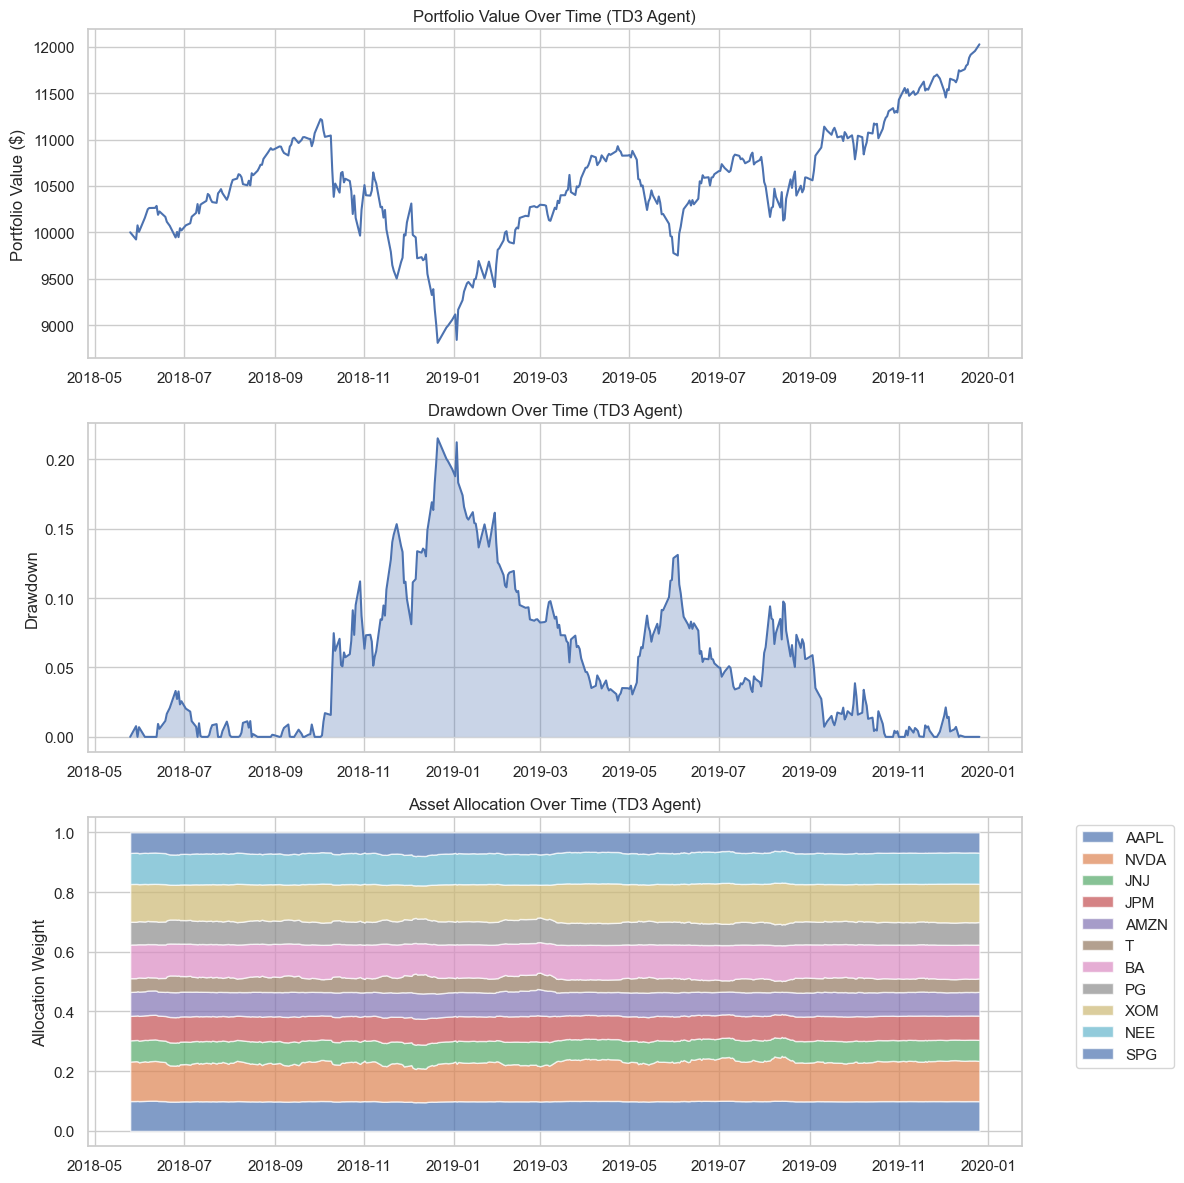

In [11]:
# -----------------------
# TD3 Agent
# -----------------------
td3_agent = TD3Agent(
    train_env,
    episodes=episodes,
    max_steps=max_steps,
    actor_lr=1e-4,
    critic_lr=1e-3,
    gamma=0.99,
    tau=0.005,
    policy_noise=0.2,
    noise_clip=0.5,
    policy_delay=2,
    batch_size=128,
    buffer_size=int(2e5),
    warmup_steps=500,
    updates_per_step=1,
    seed=SEED
)
td3_rewards = load_or_train(td3_agent, TD3_CHECKPOINT_PATH)

td3_test_reward, td3_values, td3_allocations = td3_agent.test(td3_test_env, deterministic=True)
td3_metrics = td3_test_env.evaluate_performance()
for metric, value in td3_metrics.items():
    print(f"TD3 {metric}: {value:.4f}")

plot_training_results([td3_rewards])
plot_portfolio_evaluation(td3_test_env, title_suffix="(TD3 Agent)")

Loading checkpoint from ./checkpoints/ppo_checkpoint.pth ...
PPO checkpoint loaded from ./checkpoints/ppo_checkpoint.pth
PPO Cumulative Return: 0.1943
PPO Annualized Return: 0.1246
PPO Annualized Volatility: 0.1789
PPO Sharpe Ratio: 0.7462
PPO Max Drawdown: 0.2642


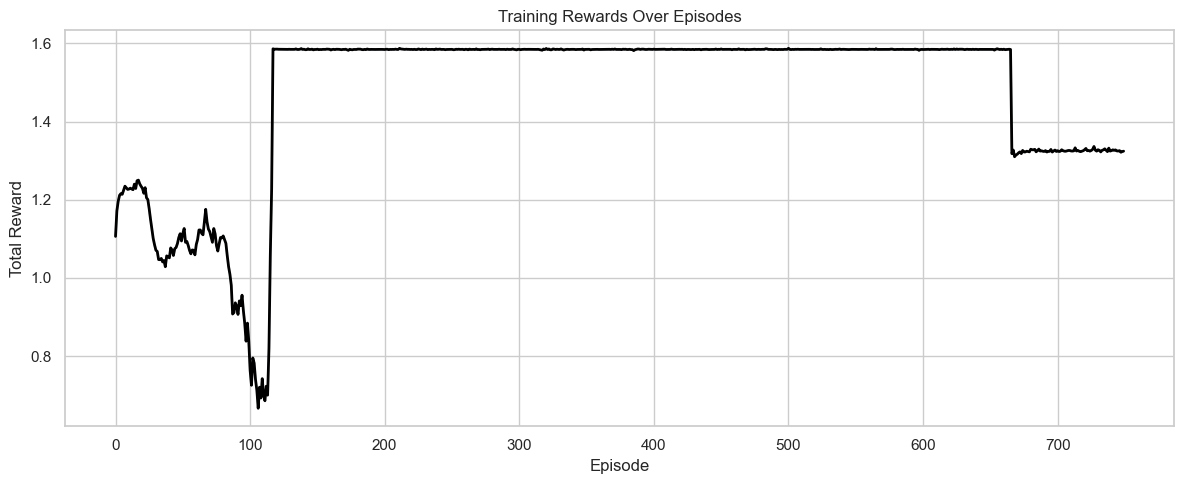


Final Allocation Percentages:
  AAPL: 17.42%
  NVDA: 17.50%
  JPM: 17.46%
  BA: 17.46%
  XOM: 12.70%
  NEE: 17.47%


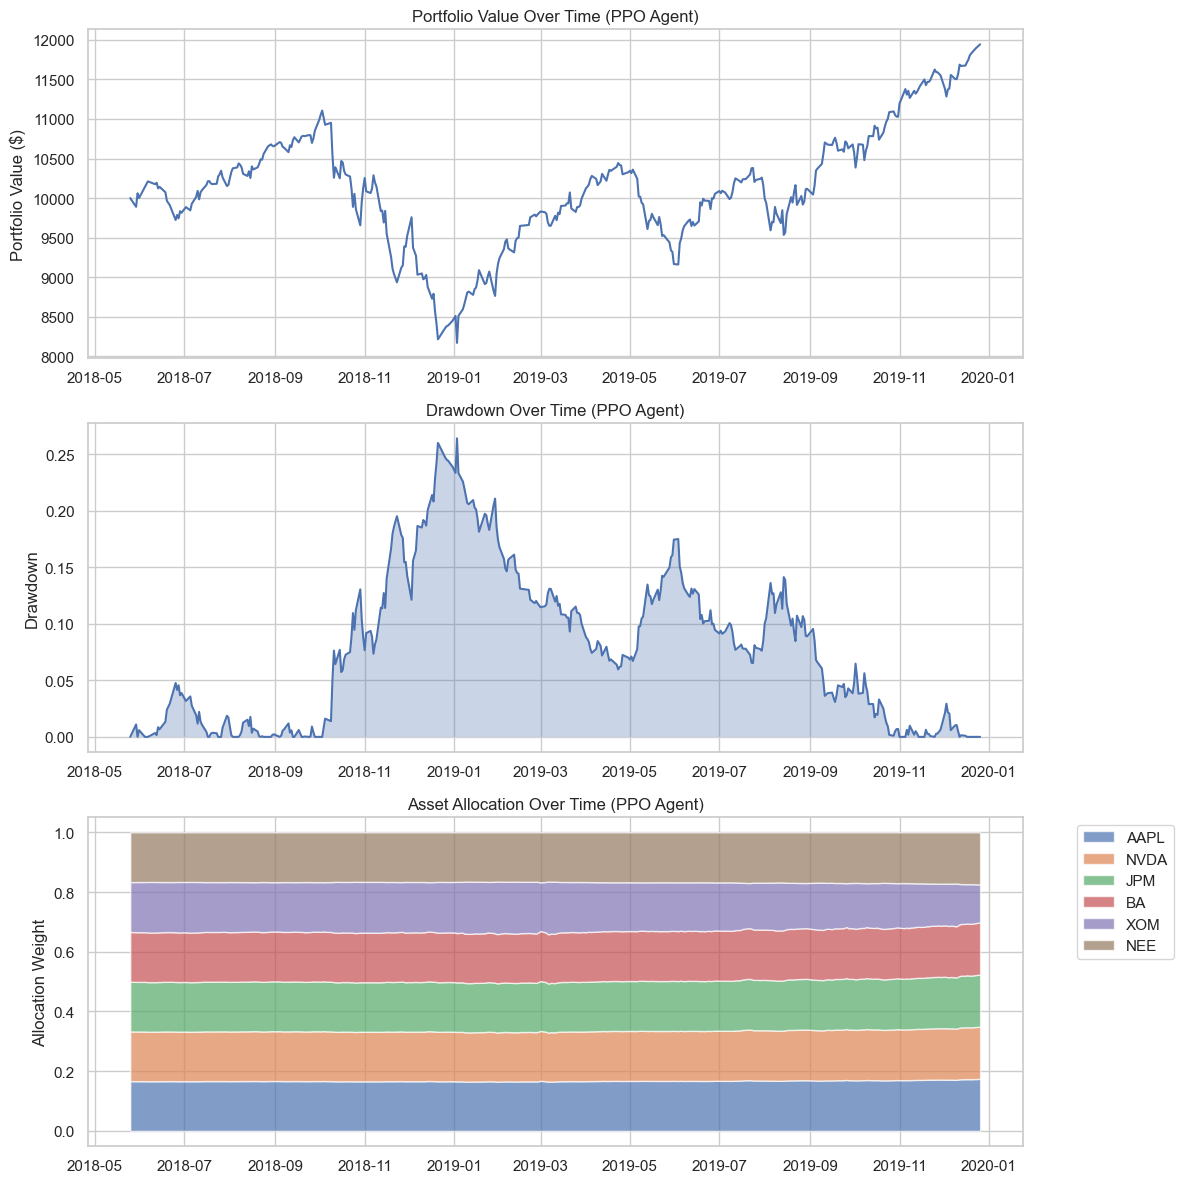

In [12]:
# -----------------------
# PPO Agent
# -----------------------
ppo_agent = PPOAgent(
    train_env,
    episodes=episodes,
    max_steps=max_steps,
    actor_lr=3e-4,
    critic_lr=1e-3,
    gamma=0.99,
    gae_lambda=0.95,
    clip_epsilon=0.2,
    entropy_coef=0.09,
    value_coef=0.5,
    epochs=10,
    minibatch_size=64,
    temperature=20.0,
    seed=SEED,
)
ppo_rewards = load_or_train(ppo_agent, PPO_CHECKPOINT_PATH)

ppo_test_reward, ppo_values, ppo_allocations = ppo_agent.test(ppo_test_env, deterministic=True)
ppo_metrics = ppo_test_env.evaluate_performance()
for metric, value in ppo_metrics.items():
    print(f"PPO {metric}: {value:.4f}")

plot_training_results([ppo_rewards])
plot_portfolio_evaluation(ppo_test_env, title_suffix="(PPO Agent)")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


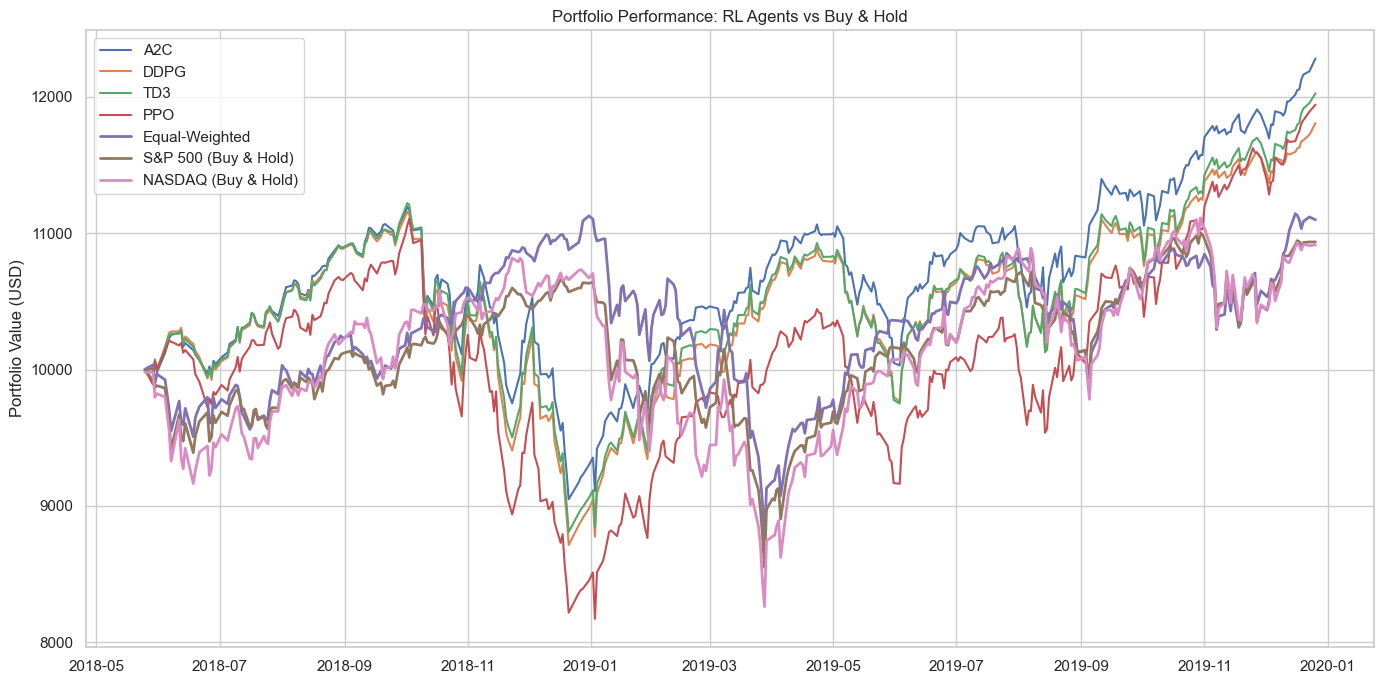


=== Performance Metrics Comparison ===
      Cumulative Return  Annualized Return  Annualized Volatility  \
A2C              0.2282             0.1456                 0.1437   
DDPG             0.1808             0.1162                 0.1589   
TD3              0.2026             0.1298                 0.1569   
PPO              0.1943             0.1246                 0.1789   

      Sharpe Ratio  Max Drawdown  
A2C         1.0183        0.1917  
DDPG        0.7718        0.2190  
TD3         0.8568        0.2150  
PPO         0.7462        0.2642  


In [13]:
# =====================================================
# Benchmark Comparison
# =====================================================
ohlcv_close = ohlcv_data['Close']

# Load benchmarks: S&P 500 and NASDAQ
sp500_data = get_ohlcv_data(['^GSPC'])
sp_close = sp500_data['Close']

nasdaq_data = get_ohlcv_data(['^IXIC'])
nasdaq_close = nasdaq_data['Close']

# Equal-weighted portfolio of stocks in dataset
portfolio_value_stocks = benchmark(ohlcv_close)
portfolio_value_sp500 = benchmark(sp_close)
portfolio_value_nasdaq = benchmark(nasdaq_close)

# Ensure equal length for fair comparison
min_len = min(
    len(a2c_values), len(ddpg_values), len(td3_values), len(ppo_values), 
    len(portfolio_value_stocks), len(portfolio_value_sp500), len(portfolio_value_nasdaq)
)

# Slice all series to same length
agents_data = {
    "A2C": a2c_values[:min_len],
    "DDPG": ddpg_values[:min_len],
    "TD3": td3_values[:min_len],
    "PPO": ppo_values[:min_len]
}
benchmark_data = {
    "Equal-Weighted": portfolio_value_stocks[:min_len],
    "S&P 500 (Buy & Hold)": portfolio_value_sp500[:min_len],
    "NASDAQ (Buy & Hold)": portfolio_value_nasdaq[:min_len]
}
dates = a2c_test_env.history_dates[:min_len]

# Plot comparison
compare_performance(agents_data, benchmark_data, dates, "Portfolio Performance: RL Agents vs Buy & Hold")

# Print metrics table
print("\n=== Performance Metrics Comparison ===")
metrics_data = {"A2C": a2c_metrics, "DDPG": ddpg_metrics, "TD3": td3_metrics, "PPO": ppo_metrics}
metrics_df = pd.DataFrame(metrics_data).T
print(metrics_df.round(4))

In [14]:
# ==========================================================
# Sliding Window Cross-Validation
# ==========================================================

def generate_k_sliding_window_folds(n_total, n_folds=5, train_ratio=0.6, test_ratio=0.2):
    """
    Generate sliding-window folds for time-series cross-validation.

    Parameters
    ----------
    n_total : int
        Total number of data points.
    n_folds : int, optional (default=5)
        Number of folds to generate.
    train_ratio : float, optional (default=0.6)
        Fraction of each fold span used for training.
    test_ratio : float, optional (default=0.2)
        Fraction of each fold span used for testing.

    Returns
    -------
    folds : list of tuple(slice, slice)
        List of (train_slice, test_slice) tuples for each fold.
    train_size : int
        Number of samples in the training set per fold.
    test_size : int
        Number of samples in the testing set per fold.
    num_folds : int
        Number of folds generated.
    """
    if train_ratio + test_ratio > 1.0:
        raise ValueError("train_ratio + test_ratio must be <= 1.0")

    fold_span = int(n_total / n_folds)
    train_size = int(fold_span * train_ratio)
    test_size = int(fold_span * test_ratio)

    if train_size + test_size > n_total:
        raise ValueError("Train + test size too large for the dataset")

    folds = []
    for i in range(n_folds):
        # Slide folds so that the last test set ends at the dataset boundary
        start = int(i * (n_total - train_size - test_size) / (n_folds - 1))
        train_start = start
        test_start = train_start + train_size

        # Ensure test set does not exceed dataset
        if test_start + test_size > n_total:
            test_start = n_total - test_size
            train_start = test_start - train_size

        folds.append((
            slice(train_start, train_start + train_size),
            slice(test_start, test_start + test_size)
        ))

    return folds, train_size, test_size, len(folds)

In [15]:
# ==========================================================
# Fold Preparation
# ==========================================================

# 1. Generate folds based on your dataset length
n_total = len(ohlcv_data['Close'])
folds, train_size, test_size, num_folds = generate_k_sliding_window_folds(
    n_total=n_total, n_folds=5, train_ratio=0.6, test_ratio=0.2
)

# 2. Collect fold results
fold_results = []
for fold_num, (train_slice, test_slice) in enumerate(folds):
    idx = ohlcv_data['Close'].index

    # Convert slice to date indices for consistency across datasets
    train_idx = idx[train_slice]
    test_idx = idx[test_slice]

    # Align indices with indicators and sentiments (if provided)
    common_train_idx = train_idx
    common_test_idx = test_idx

    if indicators is not None:
        for ticker in indicators:
            common_train_idx = common_train_idx.intersection(indicators[ticker].index)
            common_test_idx = common_test_idx.intersection(indicators[ticker].index)

    if sentiments is not None:
        common_train_idx = common_train_idx.intersection(sentiments.index)
        common_test_idx = common_test_idx.intersection(sentiments.index)

    # Slice datasets
    price_train = ohlcv_data['Close'].loc[common_train_idx]
    price_test = ohlcv_data['Close'].loc[common_test_idx]

    indicator_train = {t: indicators[t].loc[common_train_idx] for t in indicators} if indicators else None
    indicator_test = {t: indicators[t].loc[common_test_idx] for t in indicators} if indicators else None

    sentiment_train = sentiments.loc[common_train_idx] if sentiments is not None else None
    sentiment_test = sentiments.loc[common_test_idx] if sentiments is not None else None

    fold_results.append({
        'fold': fold_num,
        'price_train': price_train,
        'price_test': price_test,
        'indicator_train': indicator_train,
        'indicator_test': indicator_test,
        'sentiment_train': sentiment_train,
        'sentiment_test': sentiment_test,
    })


In [16]:
# ==========================================================
# Training / Testing Utilities
# ==========================================================

EPISODES = 150
CHECKPOINT_DIR = "./checkpoints/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def load_or_train(agent, checkpoint_path, train=True):
    """
    Load an agent checkpoint if available, otherwise train and save.

    Parameters
    ----------
    agent : RL agent instance
        The reinforcement learning agent (A2C, DDPG, TD3, PPO, etc.).
    checkpoint_path : str
        Path to save/load the checkpoint.
    train : bool, optional (default=True)
        If True, train the agent when checkpoint not found.

    Returns
    -------
    rewards_history : list
        Training rewards history.
    """
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path} ...")
        agent.load_checkpoint(checkpoint_path)
        rewards_history = getattr(agent, "training_rewards", [])
    elif train:
        print(f"Training agent and saving checkpoint to {checkpoint_path} ...")
        rewards_history = agent.train()
        agent.save_checkpoint(checkpoint_path)
    else:
        rewards_history = []
    return rewards_history


=== Fold 0 (A2C) ===
Loading checkpoint from ./checkpoints/a2c_fold_0_checkpoint.pth ...
[A2C] Checkpoint loaded ← ./checkpoints/a2c_fold_0_checkpoint.pth (episodes=150, rewards=150)
A2C Test Reward (Fold 0): 0.03
A2C Cumulative Return (Fold 0): 0.0313
A2C Annualized Return (Fold 0): 0.1228
A2C Annualized Volatility (Fold 0): 0.1307
A2C Sharpe Ratio (Fold 0): 0.9514
A2C Max Drawdown (Fold 0): 0.0763

=== Fold 1 (A2C) ===
Loading checkpoint from ./checkpoints/a2c_fold_1_checkpoint.pth ...
[A2C] Checkpoint loaded ← ./checkpoints/a2c_fold_1_checkpoint.pth (episodes=150, rewards=150)
A2C Test Reward (Fold 1): 0.04
A2C Cumulative Return (Fold 1): 0.0388
A2C Annualized Return (Fold 1): 0.1447
A2C Annualized Volatility (Fold 1): 0.1163
A2C Sharpe Ratio (Fold 1): 1.2210
A2C Max Drawdown (Fold 1): 0.0680

=== Fold 2 (A2C) ===
Loading checkpoint from ./checkpoints/a2c_fold_2_checkpoint.pth ...
[A2C] Checkpoint loaded ← ./checkpoints/a2c_fold_2_checkpoint.pth (episodes=150, rewards=150)
A2C Test

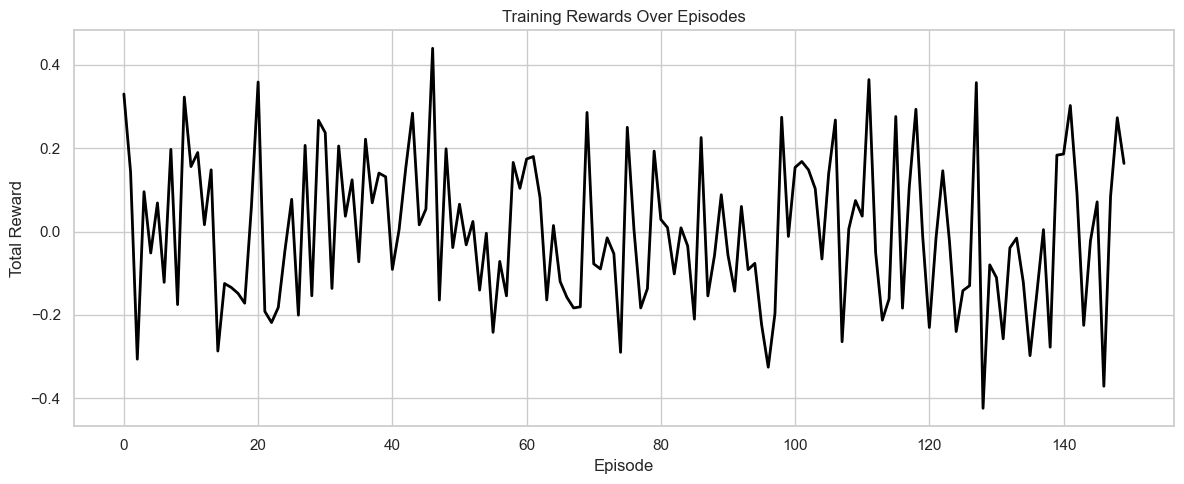


Final Allocation Percentages:
  AAPL: 7.15%
  NVDA: 6.74%
  JNJ: 13.88%
  JPM: 4.26%
  AMZN: 6.56%
  T: 12.95%
  BA: 8.39%
  PG: 6.81%
  XOM: 10.35%
  NEE: 8.43%
  SPG: 14.48%


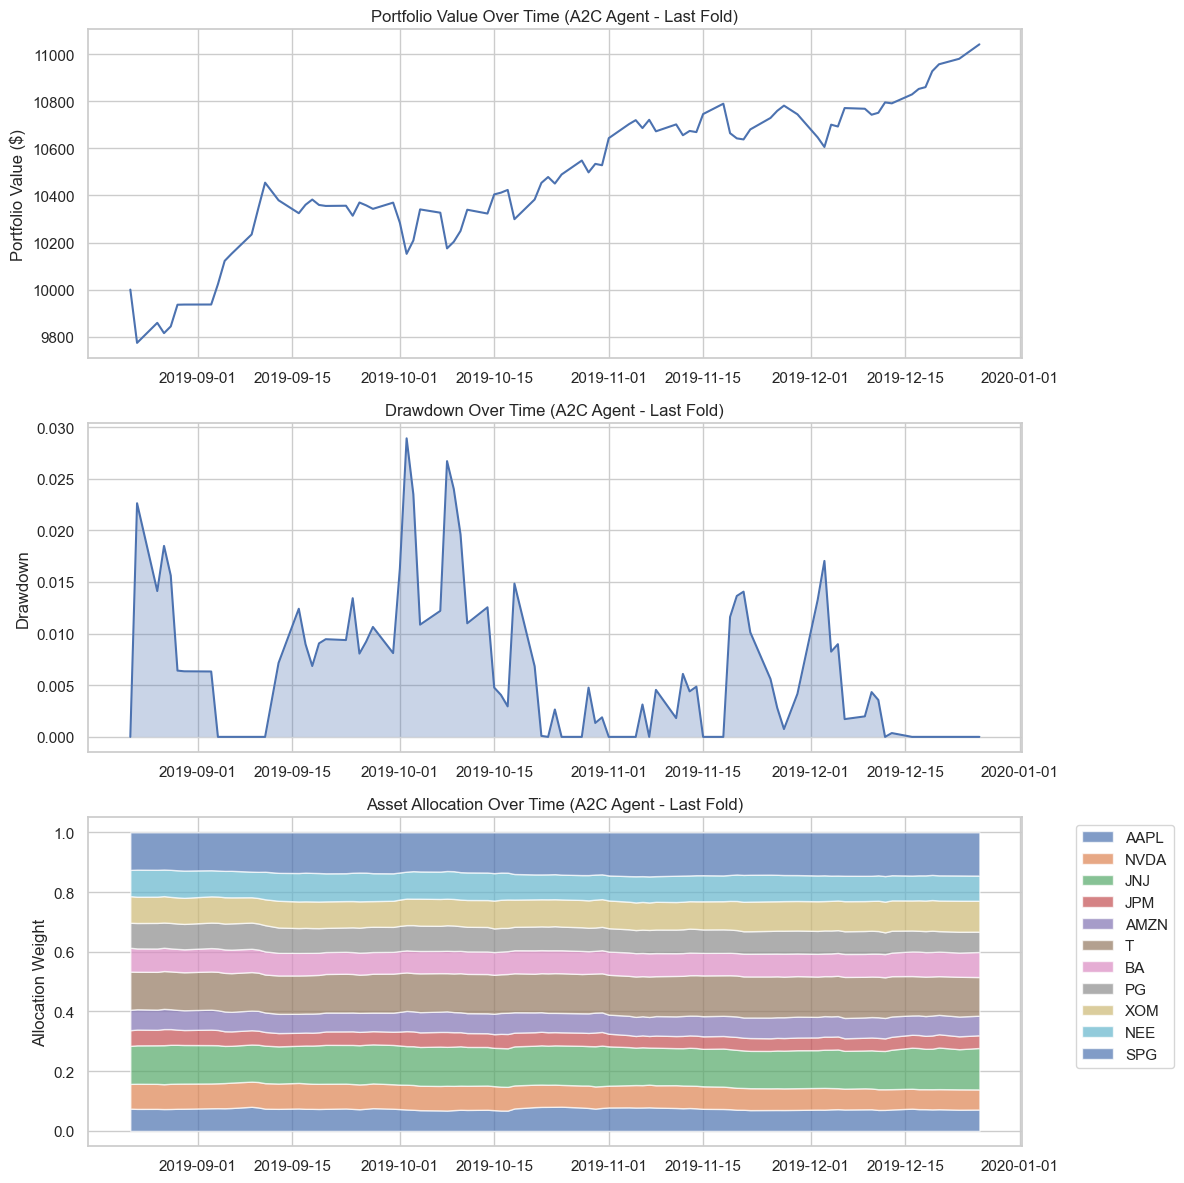

In [17]:
# ==========================================================
# Cross-Validation Training/Evaluation for Each Agent
# ==========================================================

# -------------------------
# A2C Agent: Fold-based Training and Evaluation
# -------------------------

all_folds_metrics = defaultdict(list)
test_envs = []

for fold_result in fold_results:
    fold_num = fold_result['fold']
    print(f"\n=== Fold {fold_num} (A2C) ===")

    # Prepare environments
    price_train, price_test = fold_result['price_train'], fold_result['price_test']
    indicator_train, indicator_test = fold_result['indicator_train'], fold_result['indicator_test']
    sentiment_train, sentiment_test = fold_result['sentiment_train'], fold_result['sentiment_test']

    train_env = PortfolioEnv(price_train, indicator_train, sentiment_train, initial_balance=10000)
    train_env.reset(seed=SEED)
    test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)
    test_envs.append(test_env)

    # Define agent and checkpoint
    max_steps = train_env.max_steps
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"a2c_fold_{fold_num}_checkpoint.pth")

    a2c_agent = A2CAgent(
        train_env,
        max_steps=max_steps,
        episodes=EPISODES,
        learning_rate=0.001,
        seed=SEED
    )

    # Train or load
    a2c_rewards_history = load_or_train(a2c_agent, checkpoint_path)

    # Test agent
    a2c_test_reward, _, _ = a2c_agent.test(test_env)
    print(f"A2C Test Reward (Fold {fold_num}): {a2c_test_reward:.2f}")

    # Evaluate
    a2c_metrics = test_env.evaluate_performance()
    for metric, value in a2c_metrics.items():
        print(f"A2C {metric} (Fold {fold_num}): {value:.4f}")
        all_folds_metrics[metric].append(value)

# Average metrics across folds
print("\n=== Average A2C Evaluation Across All Folds ===")
for metric, values in all_folds_metrics.items():
    avg, std = np.mean(values), np.std(values)
    print(f"{metric}: {avg:.4f} ± {std:.4f}")

# Visualization (last fold)
plot_training_results([a2c_rewards_history])
plot_portfolio_evaluation(test_envs[-1], title_suffix="(A2C Agent - Last Fold)")



=== Fold 0 (DDPG) ===
Loading checkpoint from ./checkpoints/ddpg_fold_0_checkpoint.pth ...
DDPG loaded <- ./checkpoints/ddpg_fold_0_checkpoint.pth
DDPG Test Reward (Fold 0): 0.09
DDPG Cumulative Return (Fold 0): 0.0944
DDPG Annualized Return (Fold 0): 0.4041
DDPG Annualized Volatility (Fold 0): 0.1367
DDPG Sharpe Ratio (Fold 0): 2.5518
DDPG Max Drawdown (Fold 0): 0.0560

=== Fold 1 (DDPG) ===
Loading checkpoint from ./checkpoints/ddpg_fold_1_checkpoint.pth ...
DDPG loaded <- ./checkpoints/ddpg_fold_1_checkpoint.pth
DDPG Test Reward (Fold 1): -0.02
DDPG Cumulative Return (Fold 1): -0.0156
DDPG Annualized Return (Fold 1): -0.0542
DDPG Annualized Volatility (Fold 1): 0.1445
DDPG Sharpe Ratio (Fold 1): -0.3129
DDPG Max Drawdown (Fold 1): 0.0687

=== Fold 2 (DDPG) ===
Loading checkpoint from ./checkpoints/ddpg_fold_2_checkpoint.pth ...
DDPG loaded <- ./checkpoints/ddpg_fold_2_checkpoint.pth
DDPG Test Reward (Fold 2): 0.04
DDPG Cumulative Return (Fold 2): 0.0441
DDPG Annualized Return (Fold

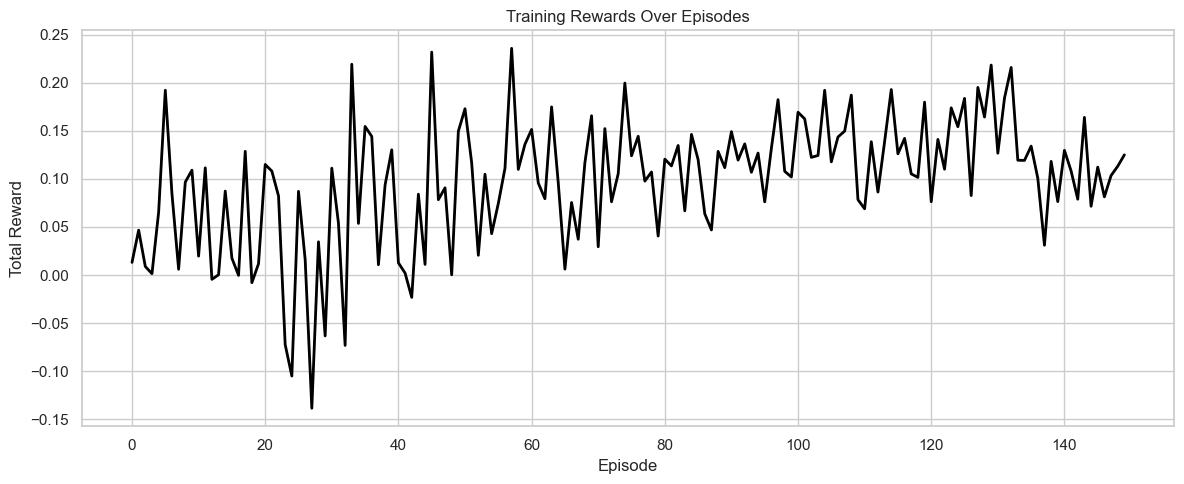


Final Allocation Percentages:
  AAPL: 4.62%
  NVDA: 3.81%
  JNJ: 6.80%
  JPM: 5.47%
  AMZN: 7.83%
  T: 4.74%
  BA: 2.08%
  PG: 28.10%
  XOM: 3.74%
  NEE: 18.47%
  SPG: 14.34%


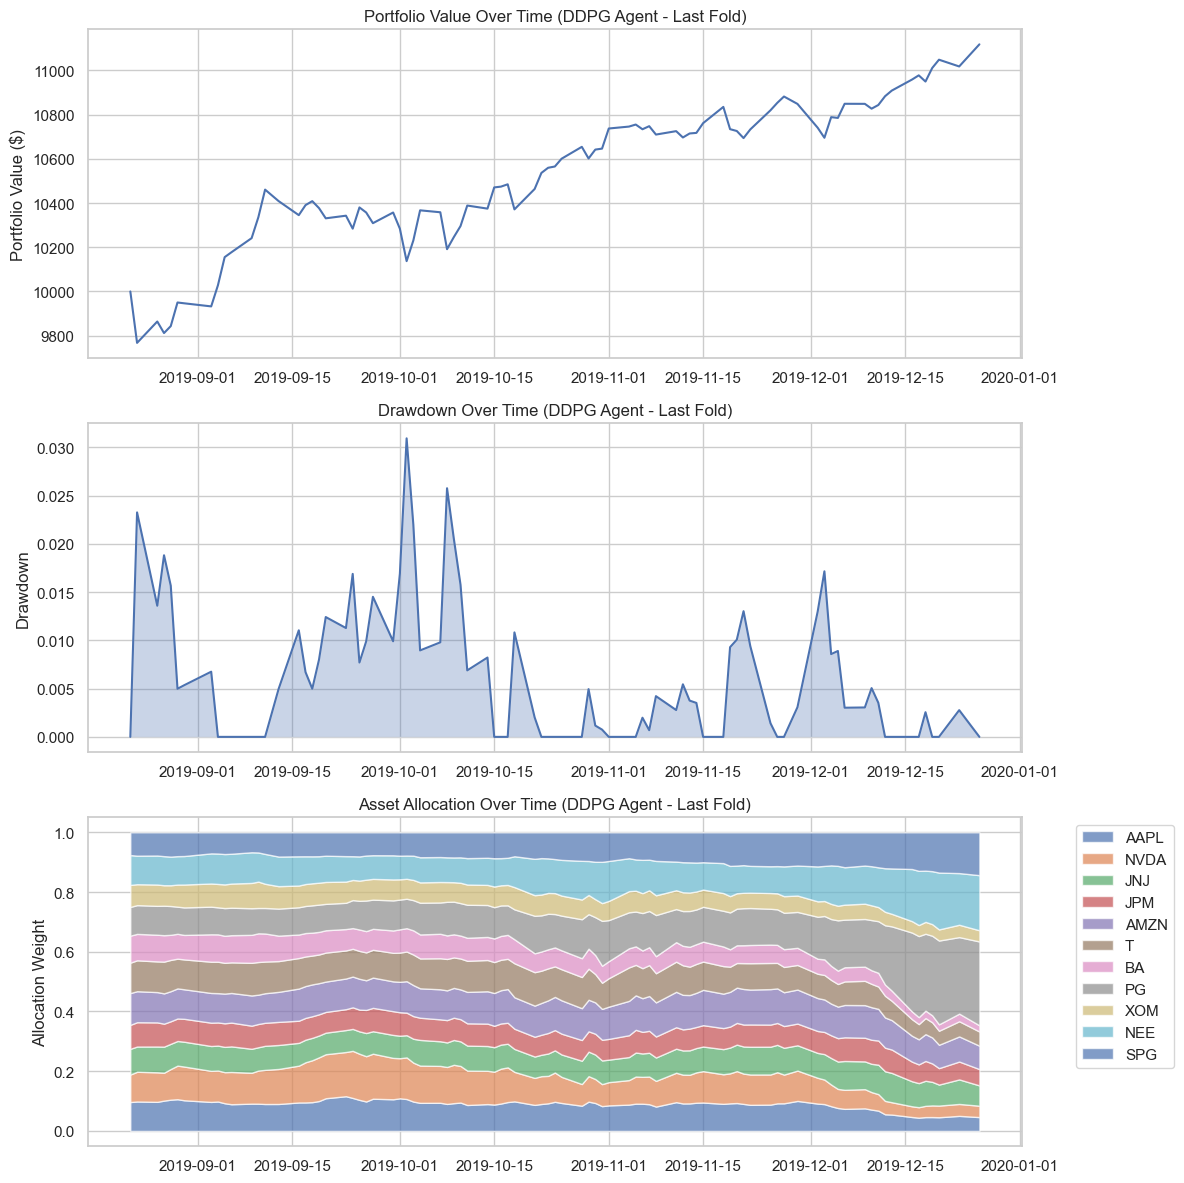

In [18]:
# ==========================
# DDPG: Fold-based Training and Evaluation
# ==========================
DDPG_CHECKPOINT_DIR = "./checkpoints/"
os.makedirs(DDPG_CHECKPOINT_DIR, exist_ok=True)

ddpg_all_folds_metrics = defaultdict(list)
ddpg_test_envs = []

for fold_result in fold_results:
    fold_num = fold_result['fold']
    print(f"\n=== Fold {fold_num} (DDPG) ===")

    # Extract train/test data for this fold
    price_train = fold_result['price_train']
    price_test = fold_result['price_test']
    indicator_train = fold_result['indicator_train']
    indicator_test = fold_result['indicator_test']
    sentiment_train = fold_result['sentiment_train']
    sentiment_test = fold_result['sentiment_test']

    # Create training environment
    train_env = PortfolioEnv(price_train, indicator_train, sentiment_train, initial_balance=10000)
    train_env.reset(seed=SEED)

    # Create testing environment
    test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)
    ddpg_test_envs.append(test_env)

    # Max steps per episode
    max_steps = train_env.max_steps

    # Define checkpoint path
    ddpg_checkpoint_path = os.path.join(DDPG_CHECKPOINT_DIR, f"ddpg_fold_{fold_num}_checkpoint.pth")

    # Initialize DDPG agent
    ddpg_agent = DDPGAgent(
        env=train_env,
        episodes=EPISODES,
        actor_lr=1e-4,
        critic_lr=1e-3,
        buffer_size=int(2e5),
        batch_size=256,
        warmup_steps=1000,
        noise_start=0.2,
        noise_end=0.05,
        noise_decay_episodes=EPISODES // 2,
        seed=SEED
    )

    # Train or load agent
    ddpg_rewards_history = load_or_train(ddpg_agent, ddpg_checkpoint_path)

    # Test agent
    ddpg_test_reward, ddpg_values, ddpg_allocations = ddpg_agent.test(test_env)
    print(f"DDPG Test Reward (Fold {fold_num}): {ddpg_test_reward:.2f}")

    # Evaluate metrics
    ddpg_metrics = test_env.evaluate_performance()
    for metric, value in ddpg_metrics.items():
        print(f"DDPG {metric} (Fold {fold_num}): {value:.4f}")
        ddpg_all_folds_metrics[metric].append(value)

# Average and std across folds
print("\n=== Average DDPG Evaluation Across All Folds ===")
for metric, values in ddpg_all_folds_metrics.items():
    avg = np.mean(values)
    std = np.std(values)
    print(f"{metric}: {avg:.4f} ± {std:.4f}")

# Plot results for last fold
plot_training_results([ddpg_rewards_history])
plot_portfolio_evaluation(ddpg_test_envs[-1], title_suffix="(DDPG Agent - Last Fold)")



=== Fold 0 (TD3) ===
Loading checkpoint from ./checkpoints/td3_fold_0_checkpoint.pth ...
TD3 checkpoint loaded from ./checkpoints/td3_fold_0_checkpoint.pth
TD3 Test Reward (Fold 0): 0.03
TD3 Cumulative Return (Fold 0): 0.0278
TD3 Annualized Return (Fold 0): 0.1086
TD3 Annualized Volatility (Fold 0): 0.1404
TD3 Sharpe Ratio (Fold 0): 0.8048
TD3 Max Drawdown (Fold 0): 0.0864

=== Fold 1 (TD3) ===
Loading checkpoint from ./checkpoints/td3_fold_1_checkpoint.pth ...
TD3 checkpoint loaded from ./checkpoints/td3_fold_1_checkpoint.pth
TD3 Test Reward (Fold 1): 0.03
TD3 Cumulative Return (Fold 1): 0.0351
TD3 Annualized Return (Fold 1): 0.1303
TD3 Annualized Volatility (Fold 1): 0.1183
TD3 Sharpe Ratio (Fold 1): 1.0949
TD3 Max Drawdown (Fold 1): 0.0694

=== Fold 2 (TD3) ===
Loading checkpoint from ./checkpoints/td3_fold_2_checkpoint.pth ...
TD3 checkpoint loaded from ./checkpoints/td3_fold_2_checkpoint.pth
TD3 Test Reward (Fold 2): 0.05
TD3 Cumulative Return (Fold 2): 0.0526
TD3 Annualized Retu

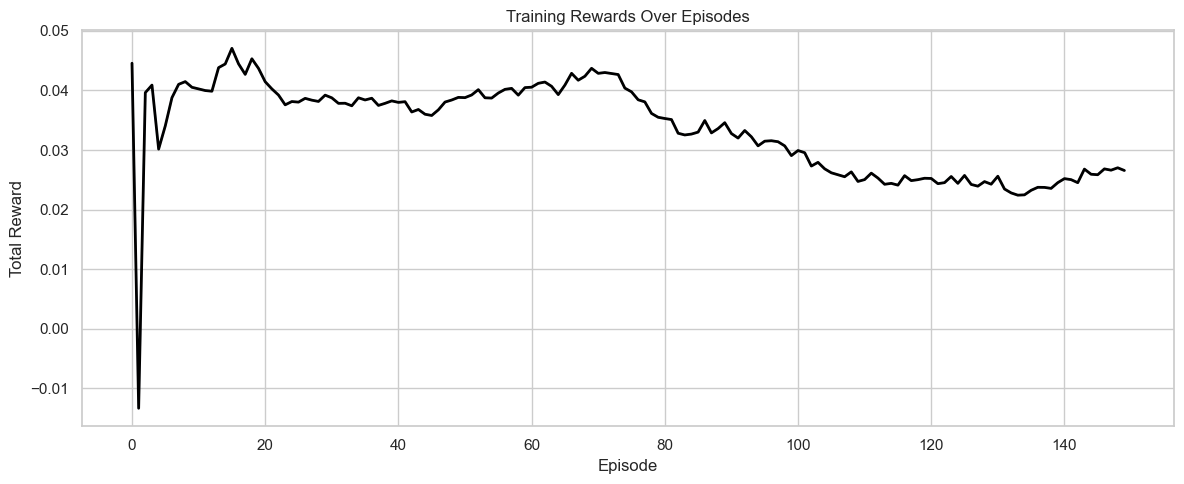


Final Allocation Percentages:
  AAPL: 8.13%
  NVDA: 9.64%
  JNJ: 9.40%
  JPM: 10.05%
  AMZN: 10.23%
  T: 8.10%
  BA: 10.09%
  PG: 8.57%
  XOM: 7.70%
  NEE: 8.27%
  SPG: 9.82%


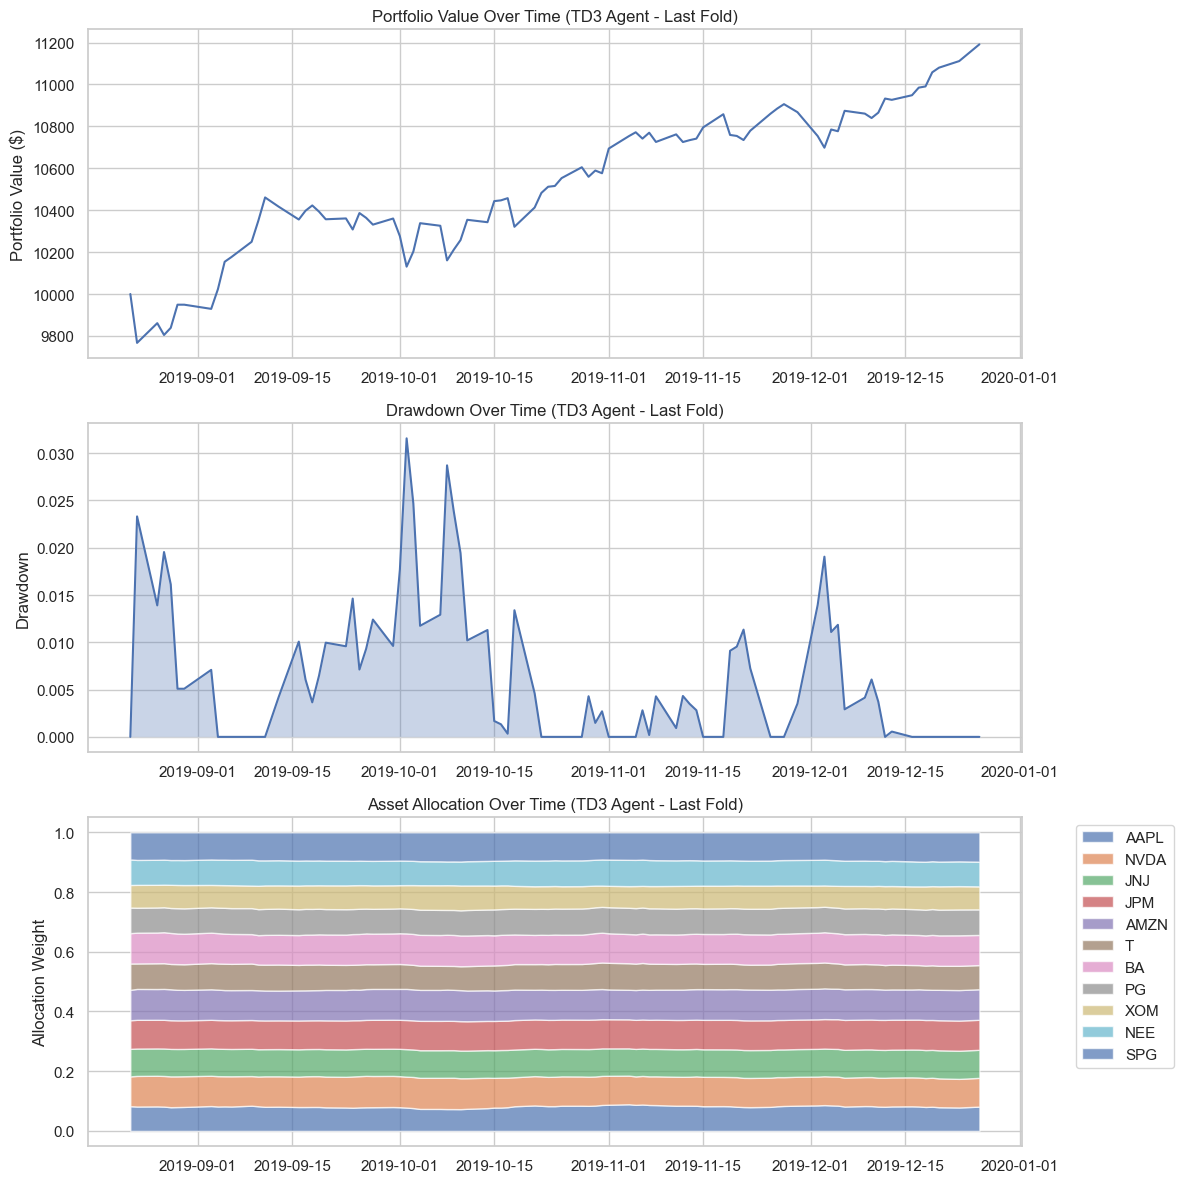

In [19]:
# ==========================
# TD3: Fold-based Training and Evaluation
# ==========================
TD3_CHECKPOINT_DIR = "./checkpoints/"
os.makedirs(TD3_CHECKPOINT_DIR, exist_ok=True)

td3_all_folds_metrics = defaultdict(list)
td3_test_envs = []

for fold_result in fold_results:
    fold_num = fold_result['fold']
    print(f"\n=== Fold {fold_num} (TD3) ===")

    # Extract fold data
    price_train = fold_result['price_train']
    price_test = fold_result['price_test']
    indicator_train = fold_result['indicator_train']
    indicator_test = fold_result['indicator_test']
    sentiment_train = fold_result['sentiment_train']
    sentiment_test = fold_result['sentiment_test']

    # Training environment
    train_env = PortfolioEnv(price_train, indicator_train, sentiment_train, initial_balance=10000)
    train_env.reset(seed=SEED)

    # Testing environment
    test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)
    td3_test_envs.append(test_env)

    # Max steps
    max_steps = train_env.max_steps

    # Checkpoint path
    td3_checkpoint_path = os.path.join(TD3_CHECKPOINT_DIR, f"td3_fold_{fold_num}_checkpoint.pth")

    # Initialize TD3 agent
    td3_agent = TD3Agent(
        env=train_env,
        episodes=EPISODES,
        max_steps=max_steps,
        actor_lr=1e-4,
        critic_lr=1e-3,
        gamma=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_delay=2,
        batch_size=128,
        buffer_size=int(2e5),
        warmup_steps=500,
        updates_per_step=1,
        seed=SEED
    )

    # Train or load
    td3_rewards_history = load_or_train(td3_agent, td3_checkpoint_path)

    # Test agent
    td3_test_reward, td3_values, td3_allocations = td3_agent.test(test_env, deterministic=True)
    print(f"TD3 Test Reward (Fold {fold_num}): {td3_test_reward:.2f}")

    # Evaluate metrics
    td3_metrics = test_env.evaluate_performance()
    for metric, value in td3_metrics.items():
        print(f"TD3 {metric} (Fold {fold_num}): {value:.4f}")
        td3_all_folds_metrics[metric].append(value)

# Average and std
print("\n=== Average TD3 Evaluation Across All Folds ===")
for metric, values in td3_all_folds_metrics.items():
    avg = np.mean(values)
    std = np.std(values)
    print(f"{metric}: {avg:.4f} ± {std:.4f}")

# Plot last fold
plot_training_results([td3_rewards_history])
plot_portfolio_evaluation(td3_test_envs[-1], title_suffix="(TD3 Agent - Last Fold)")



=== Fold 0 (PPO) ===
Loading checkpoint from ./checkpoints/ppo_fold_0_checkpoint.pth ...
PPO checkpoint loaded from ./checkpoints/ppo_fold_0_checkpoint.pth
PPO Test Reward (Fold 0): 0.01
PPO Cumulative Return (Fold 0): 0.0112
PPO Annualized Return (Fold 0): 0.0427
PPO Annualized Volatility (Fold 0): 0.1946
PPO Sharpe Ratio (Fold 0): 0.3126
PPO Max Drawdown (Fold 0): 0.1267

=== Fold 1 (PPO) ===
Loading checkpoint from ./checkpoints/ppo_fold_1_checkpoint.pth ...
PPO checkpoint loaded from ./checkpoints/ppo_fold_1_checkpoint.pth
PPO Test Reward (Fold 1): 0.03
PPO Cumulative Return (Fold 1): 0.0257
PPO Annualized Return (Fold 1): 0.0941
PPO Annualized Volatility (Fold 1): 0.1219
PPO Sharpe Ratio (Fold 1): 0.7993
PPO Max Drawdown (Fold 1): 0.0693

=== Fold 2 (PPO) ===
Loading checkpoint from ./checkpoints/ppo_fold_2_checkpoint.pth ...
PPO checkpoint loaded from ./checkpoints/ppo_fold_2_checkpoint.pth
PPO Test Reward (Fold 2): 0.04
PPO Cumulative Return (Fold 2): 0.0387
PPO Annualized Retu

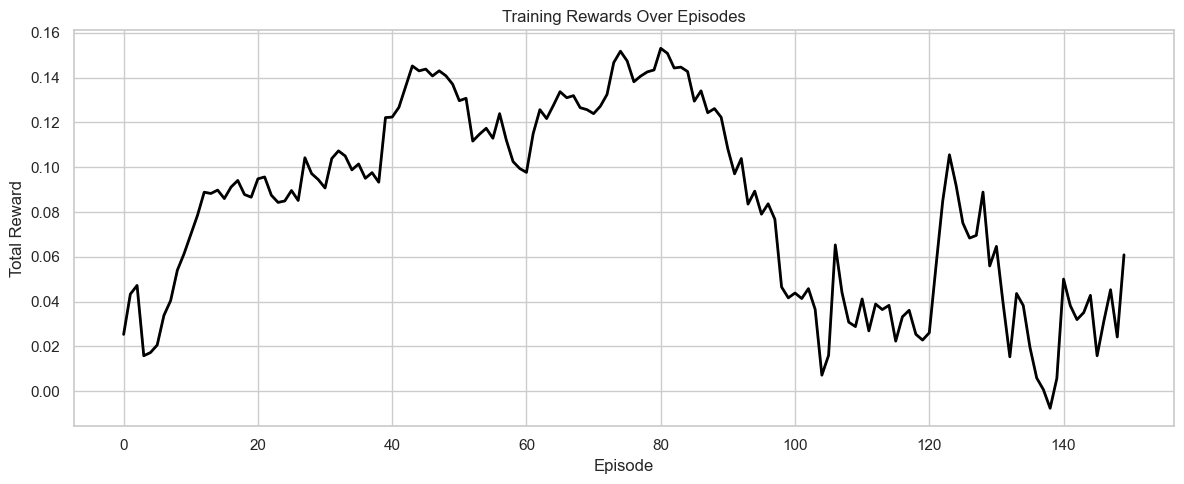


Final Allocation Percentages:
  AAPL: 19.31%
  NVDA: 27.69%
  PG: 27.76%
  NEE: 25.24%


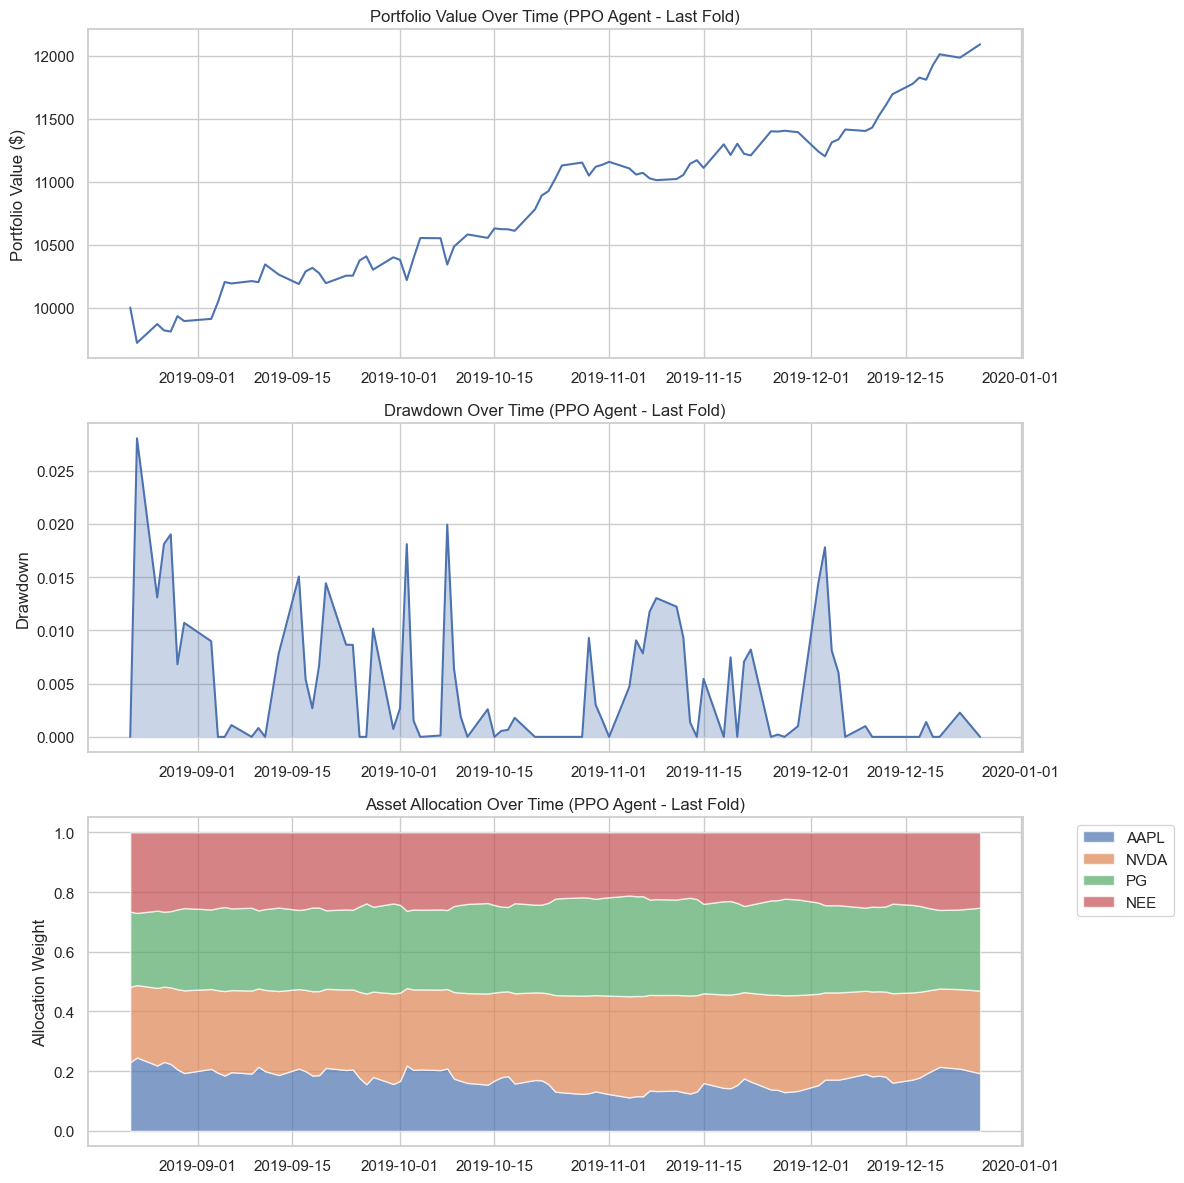

In [20]:
# ==========================
# PPO: Fold-based Training and Evaluation
# ==========================
PPO_CHECKPOINT_DIR = "./checkpoints/"
os.makedirs(PPO_CHECKPOINT_DIR, exist_ok=True)

ppo_all_folds_metrics = defaultdict(list)
ppo_test_envs = []

for fold_result in fold_results:
    fold_num = fold_result['fold']
    print(f"\n=== Fold {fold_num} (PPO) ===")

    # Extract fold data
    price_train = fold_result['price_train']
    price_test = fold_result['price_test']
    indicator_train = fold_result['indicator_train']
    indicator_test = fold_result['indicator_test']
    sentiment_train = fold_result['sentiment_train']
    sentiment_test = fold_result['sentiment_test']

    # Training environment
    train_env = PortfolioEnv(price_train, indicator_train, sentiment_train, initial_balance=10000)
    train_env.reset(seed=SEED)

    # Testing environment
    test_env = PortfolioEnv(price_test, indicator_test, sentiment_test, initial_balance=10000)
    ppo_test_envs.append(test_env)

    # Max steps
    max_steps = train_env.max_steps

    # Checkpoint path
    ppo_checkpoint_path = os.path.join(PPO_CHECKPOINT_DIR, f"ppo_fold_{fold_num}_checkpoint.pth")

    # Initialize PPO agent
    ppo_agent = PPOAgent(
        env=train_env,
        episodes=EPISODES,
        max_steps=max_steps,
        actor_lr=3e-4,
        critic_lr=1e-3,
        gamma=0.99,
        gae_lambda=0.95,
        clip_epsilon=0.2,
        entropy_coef=0.09,
        value_coef=0.5,
        epochs=10,
        minibatch_size=64,
        temperature=20.0,
        seed=SEED,
    )

    # Train or load
    ppo_rewards_history = load_or_train(ppo_agent, ppo_checkpoint_path)

    # Test agent
    ppo_test_reward, ppo_values, ppo_allocations = ppo_agent.test(test_env, deterministic=True)
    print(f"PPO Test Reward (Fold {fold_num}): {ppo_test_reward:.2f}")

    # Evaluate metrics
    ppo_metrics = test_env.evaluate_performance()
    for metric, value in ppo_metrics.items():
        print(f"PPO {metric} (Fold {fold_num}): {value:.4f}")
        ppo_all_folds_metrics[metric].append(value)

# Average and std
print("\n=== Average PPO Evaluation Across All Folds ===")
for metric, values in ppo_all_folds_metrics.items():
    avg = np.mean(values)
    std = np.std(values)
    print(f"{metric}: {avg:.4f} ± {std:.4f}")

# Plot last fold
plot_training_results([ppo_rewards_history])
plot_portfolio_evaluation(ppo_test_envs[-1], title_suffix="(PPO Agent - Last Fold)")